# Use ZhipuAI GLM-4 Vision API to analyze the population data of American cities and rural areas

**This tutorial is Only in Chinese explanation**

此代码演示了使用 GLM-4V 模型对表格进行简单对分析，模型将通过思维链的方式对一个csv表格和对应的图表进行分析，并在最后绘制出对未来美国人口城乡居民比例的预测。
我们使用来自[Our World in Data](https://ourworldindata.org/grapher/urban-vs-rural-majority?tab=chart&facet=none)的数据进行分析和预测。

为了区分图像理解模型和 LLM 的区别，我们使用了对应的图像和csv表格，分别传入给 GLM-4V 和 GLM-4 模型，对比两者的结果。

In [1]:
import os

os.environ["ZHIPUAI_API_KEY"] = "your api key"

首先，我们需要读取图片并传入给 GLM4-V模型

In [2]:
import base64
import io
from zhipuai import ZhipuAI
from PIL import Image

client = ZhipuAI()

def image_to_base64(image_path):
    """
    Convert an image to base64 encoding.
    """
    with Image.open(image_path) as image:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")  # or format="PNG", depending on your image.
        img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str


base64_image = image_to_base64("data/urban-vs-rural-majority/urban-vs-rural-majority.png")

In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "你是一个人口数据分析师，请你根据我提供的数据，分析一下美国城市的人口变化"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": base64_image
                }

            }
        ]
    }
]

我们先对这张表格进行简单的分析并得到趋势。我们将模型的回答存入历史，并为接下来的绘图工作做准备。

Through this operation, we will be able to get the model's description of this picture.

In [4]:
def add_message(role, messages, new_message):
    messages.append(
        {
            "role": role,
            "content": new_message
        }
    )
    return messages

In [5]:
response = client.chat.completions.create(
    model="glm-4v",
    messages=messages,
    top_p=0.7,
    temperature=0.9,
    max_tokens=2000,
)
add_message(response.choices[0].message.role, messages, response.choices[0].message.content)
response.choices[0].message.content

'从1500年到2050年，美国的总人口一直保持稳定增长。在18世纪后期和19世纪前期，随着工业革命的发展，人们从农村地区向城市迁移，导致城市人口快速增长。到1930年左右，美国的城市化率达到60%，之后城市人口增长速度放缓，但仍然保持了相对较高的增长率。然而，到了20世纪中期，随着城市化的饱和和郊区化的发展，美国城市的人口开始出现下降趋势。到1970年左右，美国城市的人口比例降至40%以下。与此同时，农村人口的比例则有所上升。尽管如此，美国的城市人口依然是世界上最大的城市人口之一，且其在科技、金融、文化等方面具有重要的影响力。'

接着，我们让模型完成对未来人口比例预期的绘图工作，在这里，我们使用 GLM-4V模型进行测试

In [6]:
Prompt = """
请你基于图表的数据和增长趋势，作出预测未来的城乡人口比例数据并画图。2051年开始，城市人口会继续增长，但是基本不在变动，乡村人口会下降，但是与2050的数值不会有很大变化
你应该预测2051到2055年美国的乡村和城镇人口分布比例，将预测的数据使用使用Python语言绘制，你至少应该绘制10个数据点，并且，增长率是会发生变动的，最后，你要把这些数据点连接来，成为一个图表。
你应该使用markdown进行输出，只输出Python的执行代码。
"""
add_message("user", messages, Prompt)

response = client.chat.completions.create(
    model="glm-4v",
    messages=messages,
    top_p=0.1,
    temperature=0.1,
    max_tokens=2000,
)
response.choices[0].message.content

"```python\nimport matplotlib.pyplot as plt\n\nyears = [2051, 2052, 2053, 2054, 2055]\nurban_ratio = [80,80.2,80.6,82,83]\nrural_ratio = [20,19.8,19.4,18,17]\n\nplt.figure(figsize=(10,6))\nplt.plot(years, urban_ratio, marker='o', label='Urban')\nplt.plot(years, rural_ratio, marker='o', label='Rural')\nplt.title('Do more people live in urban or rural areas? United States, 1500 to 2050')\nplt.xlabel('Year')\nplt.ylabel('Percentage')\nplt.legend()\nplt.grid(True)\nplt.show()\n```"

我们获取到了模型的Python代码返回并进行了提取和绘制，得到以下图像。

In [7]:
def execute_cleaned_code_from_string(code_string):
    import re
    pattern = r'```python\n(.*?)```'
    match = re.search(pattern, code_string, re.DOTALL)
    if match:
        clean_code_string = match.group(1)
        print("Extracted code:", clean_code_string)
        try:
            code_object = compile(clean_code_string, '<string>', 'exec')
            exec(code_object)
            return "Code executed successfully."
        except Exception as e:
            return "An error occurred: " + str(e)
    else:
        return "No Python code block found."




Extracted code: import matplotlib.pyplot as plt

years = [2051, 2052, 2053, 2054, 2055]
urban_ratio = [80,80.2,80.6,82,83]
rural_ratio = [20,19.8,19.4,18,17]

plt.figure(figsize=(10,6))
plt.plot(years, urban_ratio, marker='o', label='Urban')
plt.plot(years, rural_ratio, marker='o', label='Rural')
plt.title('Do more people live in urban or rural areas? United States, 1500 to 2050')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


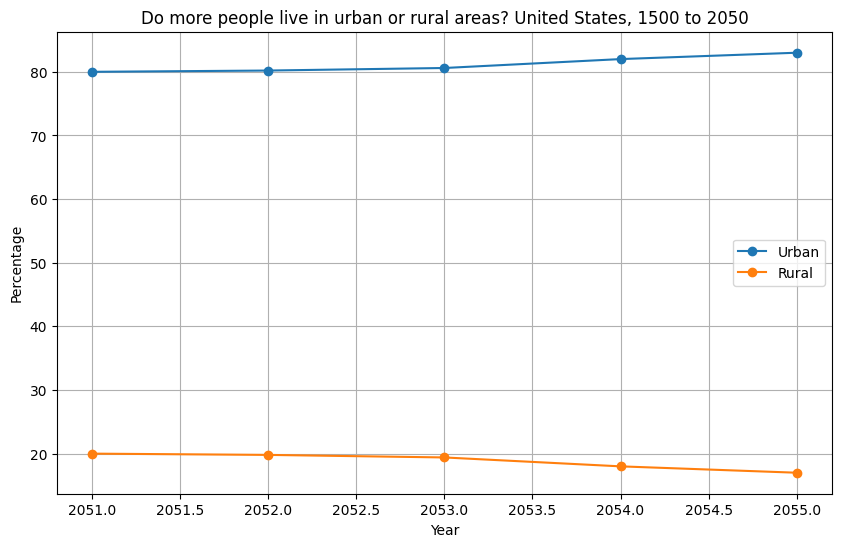

'Code executed successfully.'

In [8]:
execute_cleaned_code_from_string(response.choices[0].message.content)

## 使用 GLM-4 模型进行分析

我们用同样的数据，使用GLM-4 模型进行分析，首先，我们需要读入图片，我们先展示部分的数据。

In [9]:
import pandas as pd

file_path = 'data/urban-vs-rural-majority/urban-vs-rural-majority.csv'
urban_rural_data = pd.read_csv(file_path)
urban_rural_data.head()

/var/folders/87/sm46bt2s7hqbsj34djxvt2x40000gn/T/ipykernel_39831/501768564.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,United States,USA,1500,0.2000000029802322,99.800003
0,United States,USA,1600,0.700000,99.300003
1,United States,USA,1700,2.000000,98.000000
2,United States,USA,1790,5.132197,94.867805
3,United States,USA,1800,6.072752,93.927246
4,United States,USA,1810,7.257840,92.742157


设定好提示词，为一会模型的生成提供引导。

In [10]:
formatted_data = urban_rural_data.to_string(index=False)
sys_message = """
你是一个数据分析工程师，你将要为我分析提供的表格内容我将为你提供以下的一个表格，请你帮我分析美国城市和乡村人口比例的分布和趋势
美国, 1500到2050年居住在城市与农村地区的人口比例。此处，“大多数城市”表示超过 50% 的人口居住在城市中心； “大多数是农村人口”表示低于 50%。城市人口是根据国家统计局对城市地区的定义来定义的。这是基于对 2016 年的估计，并结合联合国对 2050 年的预测。
"""
# 构建请求内容
message = f"请分析以下城乡人口数据：\n{formatted_data}\n 重点确定不同地区和年份的城市化趋势、变化以及重要模式。请你直接返回给我结论，带有具体的数值"

# 构建 JSON 结构
request_data = [
    {
        "role": "system",
        "content": sys_message
    },
    {
        "role": "user",
        "content": message
    }
]

我们先让 GLM对读入的csv表格进行分析。

In [11]:
response = client.chat.completions.create(
    model="glm-4",
    messages=request_data,
    top_p=0.8,
    temperature=0.8,
    max_tokens=8192,
)
response.choices[0].message.content

'根据提供的数据，以下是美国从1500年到2050年城市与农村人口比例的分析结论：\n\n1. **城市化趋势**：从1500年到2050年，美国城市人口比例呈现显著增长趋势。在1500年，城市人口仅占总人口的0.2%，而到2050年，这一比例预计将增长至89.16%，城市化进程非常明显。\n\n2. **具体数值变化**：\n   - **1500年**：城市人口比例0.2%，农村人口比例99.8%\n   - **1800年**：城市人口比例6.07%，农村人口比例93.93%\n   - **1900年**：城市人口比例39.98%，农村人口比例60.02%\n   - **1950年**：城市人口比例64.15%，农村人口比例35.85%\n   - **2000年**：城市人口比例79.06%，农村人口比例20.94%\n   - **2016年**：城市人口比例81.86%，农村人口比例18.14%\n   - **2050年（预测）**：城市人口比例89.16%，农村人口比例10.84%\n\n3. **重要模式**：\n   - 在19世纪中叶（特别是1850年以后），城市化速度明显加快，这可能与工业革命和随后的移民潮有关。\n   - 20世纪中叶（特别是1950年代），城市人口比例迅速增长，这可能与二战后的经济扩张和郊区化趋势有关。\n   - 从1970年代到2000年代，城市人口比例的增长速度相对放缓，但仍然持续增长。\n   - 从2010年到2050年，预测显示城市化进程将继续，但增长速度有所放缓。\n\n这些数据表明，美国正经历着持续的城市化过程，城市人口比例不断上升，而农村人口比例相应下降。这一趋势在未来的几十年里预计仍将持续。'

接着，让 GLM-4V 模型绘图，并将结果返回给我们。

Extracted code: import matplotlib.pyplot as plt
import numpy as np

# 初始的城市和农村人口比例
nurban_ratio = [81.862]  # 2016年的城市人口比例
nrural_ratio = [18.138]  # 2016年的农村人口比例

# 要预测的年份
years = list(range(2051, 2056))

# 模拟每年城市和农村人口比例的变化
np.random.seed(0)  # 为了结果的可重复性，设置随机种子
for year in years:
    # 假设城市人口比例每年增加一个小的随机量，农村人口比例相应减少
    urban_change = np.random.uniform(0.1, 0.3)  # 城市人口增长率的随机量
    rural_change = -urban_change  # 农村人口比例变化与城市相反
    
    # 更新城市和农村人口比例
    nurban_ratio.append(max(0, min(100, nurban_ratio[-1] + urban_change)))
    nrural_ratio.append(max(0, min(100, nrural_ratio[-1] + rural_change)))

# 绘制图表
plt.figure(figsize=(10, 5))
plt.plot(years, nurban_ratio[1:], label='Urban Population Ratio')
plt.plot(years, nrural_ratio[1:], label='Rural Population Ratio')

# 连接数据点
plt.plot(years, nurban_ratio[1:], 'bo-')
plt.plot(years, nrural_ratio[1:], 'ro-')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Urban vs Rural Population Ratio Forecast (2051-2055)')
plt.xlabel('Year')
plt.ylabel('Populat

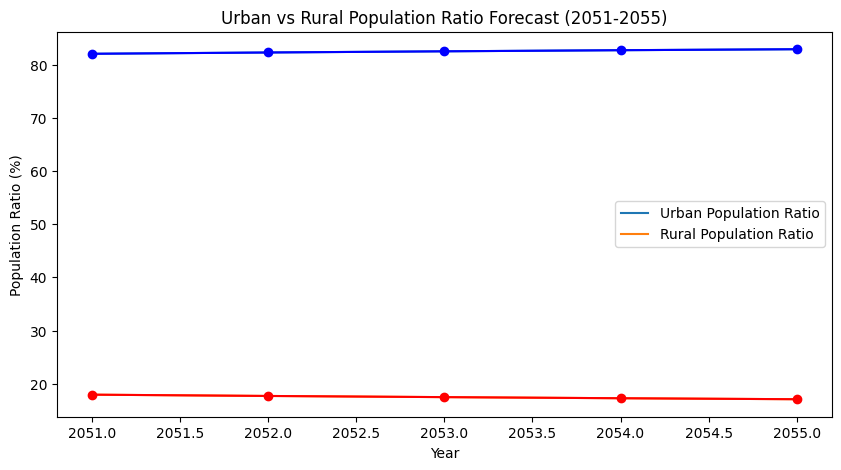

'Code executed successfully.'

In [12]:
Prompt = """
请你根据当前的分析情况，对未来的人口进行预测，基于刚才你分析的数据，预测未来的数据并画图。
你应该预测2051到2055年美国的乡村和城镇人口分布比例，将预测的数据使用使用Python语言绘制，你至少应该绘制10个数据点，并且，增长率是会发生变动的，最后，你要把这些数据点连接来，成为一个图表。
你应该使用markdown进行输出，只输出Python的执行代码。
"""
add_message("user", request_data, Prompt)
response = client.chat.completions.create(
    model="glm-4",
    messages=request_data,
    top_p=0.1,
    temperature=0.1,
    max_tokens=2000,
)
execute_cleaned_code_from_string(response.choices[0].message.content)

观察两个模型的结果，我们可以发现
1. GLM-4V 模型对于图像的理解较为准确，能够对图像的趋势进行简单的分析，虽然能够绘制出正常的结果，但是建议作为备选方案使用。
2. GLM-4 模型对于图像的理解更加精确，通过对表格准确数据的提取，获得精确的数据并绘制了较好的结果。

在绘制图像的时候，由于设计代码设计，我在尝试的时候使用较小的`temperature`和`top_p`，这样可以保证模型生成的代码更加准确。